In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
InputDir='/scratch/TESTS/Aim2/Inputs'
OutputDir='/scratch/TESTS/Aim2/Outputs'
MatlabFilesDir='/scratch/TESTS/Aim2/MatlabFiles'

label_fn = os.path.join(InputDir,'fswm_extended_neuro2012_20_merge_seg.nii.gz')
t1_fn = os.path.join(InputDir,'t1_average_BRAINSABC.nii.gz')
t2_fn = os.path.join(InputDir,'t2_average_BRAINSABC.nii.gz')
dwi_fn = os.path.join(InputDir,'DWI_Corrected_Aligned_CS.nrrd')

In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from SEMTools import *

In [4]:
from SEMTools.filtering.denoising import UnbiasedNonLocalMeans

In [5]:
DenoiseInputImgs = UnbiasedNonLocalMeans()
DenoiseInputImgs.inputs.rc = [1, 1, 1]
DenoiseInputImgs.inputs.rs = [4, 4, 4]
DenoiseInputImgs.inputs.inputVolume = t1_fn
DenoiseInputImgs.inputs.outputVolume = os.path.join(OutputDir,'t1_denoised.nii.gz')
print(DenoiseInputImgs.cmdline)
DenoiseInputImgs.run()

 UnbiasedNonLocalMeans  --rc 1,1,1 --rs 4,4,4 /scratch/TESTS/Aim2/Inputs/t1_average_BRAINSABC.nii.gz /scratch/TESTS/Aim2/Outputs/t1_denoised.nii.gz


In [6]:
DenoiseInputImgs = UnbiasedNonLocalMeans()
DenoiseInputImgs.inputs.rc = [1, 1, 1]
DenoiseInputImgs.inputs.rs = [4, 4, 4]
DenoiseInputImgs.inputs.inputVolume = t2_fn
DenoiseInputImgs.inputs.outputVolume = os.path.join(OutputDir,'t2_denoised.nii.gz')
DenoiseInputImgs.run()

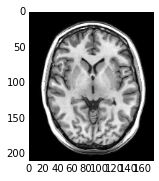

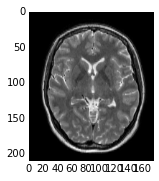

In [7]:
t1d = sitk.ReadImage(os.path.join(OutputDir,'t1_denoised.nii.gz'))
t2d = sitk.ReadImage(os.path.join(OutputDir,'t2_denoised.nii.gz'))
myshow(t1d)
myshow(t2d)

In [8]:
def ExtractBRAINFromHead(headImage, labelsMap):
    label_mask = labelsMap>0
    brainImage = sitk.Cast(headImage,sitk.sitkInt16) * sitk.Cast(label_mask,sitk.sitkInt16)
    return brainImage

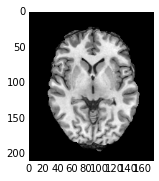

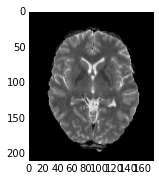

In [9]:
labelMap = sitk.ReadImage(label_fn)
t1d = ExtractBRAINFromHead(t1d,labelMap)
t2d = ExtractBRAINFromHead(t2d,labelMap)
myshow(t1d)
myshow(t2d)

In [10]:
# Now we read dwi image and extract its b0
myExtracter = extractNrrdVectorIndex()
myExtracter.inputs.inputVolume = dwi_fn
myExtracter.inputs.vectorIndex = 0
myExtracter.inputs.outputVolume = os.path.join(OutputDir,'dwi_b0.nrrd')
print(myExtracter.cmdline)
myExtracter.run()

INFO:interface:stdout 2015-12-08T16:50:49.335134:Input Image: /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd
INFO:interface:stdout 2015-12-08T16:50:49.335134:Output Image: /scratch/TESTS/Aim2/Outputs/dwi_b0.nrrd
INFO:interface:stdout 2015-12-08T16:50:49.335134:Vector Index: 0
INFO:interface:stdout 2015-12-08T16:50:49.335134:Set Image Orientation: AsAcquired
INFO:interface:stdout 2015-12-08T16:50:49.335134:


 extractNrrdVectorIndex  --inputVolume /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd --outputVolume /scratch/TESTS/Aim2/Outputs/dwi_b0.nrrd --vectorIndex 0


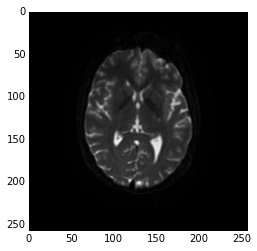

In [11]:
dwi_b0 = sitk.ReadImage(myExtracter.inputs.outputVolume)
myshow(dwi_b0)

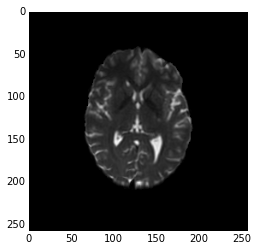

In [12]:
# Now resample the brain mask to normalized space to remove DWI skull
resampler2 = sitk.ResampleImageFilter()
resampler2.SetReferenceImage(dwi_b0)
resampler2.SetInterpolator(sitk.sitkNearestNeighbor)
labelMap = resampler2.Execute(labelMap)

dwi_b0 = ExtractBRAINFromHead(dwi_b0,labelMap)
myshow(dwi_b0)

In [13]:
# Now t1d and t2d have original t1, t2 voxel lattice with following specifications:
print(t1d.GetSize())
print(t2d.GetSize())
print(t1d.GetDirection())
print(t2d.GetDirection())
print(t1d.GetOrigin())
print(t2d.GetOrigin())

(174, 208, 186)
(174, 208, 186)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-88.5, -88.5, -89.5)
(-88.5, -88.5, -89.5)


In [14]:
print(dwi_b0.GetSize())
print(dwi_b0.GetDirection())
print(dwi_b0.GetOrigin())

(256, 256, 61)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)


In [15]:
############################
# Now JUST FOR MATLAB TEST:
############################
# resample t1d and t2d to DWI space (256x256x61)
#
resampler1 = sitk.ResampleImageFilter()
resampler1.SetReferenceImage(dwi_b0)
t1d = resampler1.Execute(t1d)
t2d = resampler1.Execute(t2d)

print(t1d.GetSize())
print(t2d.GetSize())
print(t1d.GetDirection())
print(t2d.GetDirection())
print(t1d.GetOrigin())
print(t2d.GetOrigin())

(256, 256, 61)
(256, 256, 61)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)


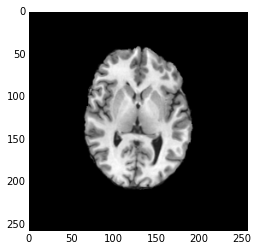

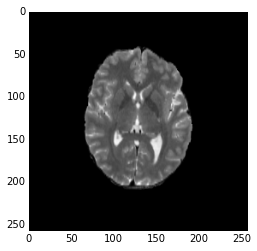

In [16]:
myshow(t1d)
myshow(t2d)

In [17]:
# Now set direction cosign of all images to identity
def ForceDCtoID(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return inputVolume

def ForceOriginToZero(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetOrigin((0.0, 0.0, 0.0))
    return inputVolume

In [18]:
dwi_b0 = ForceDCtoID(dwi_b0)
dwi = ForceOriginToZero(dwi_b0)

t1d = ForceDCtoID(t1d)
t1d = ForceOriginToZero(t1d)

t2d = ForceDCtoID(t2d)
t2d = ForceOriginToZero(t2d)

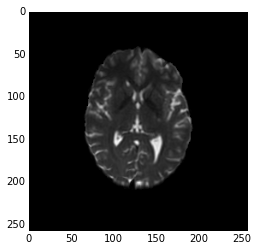

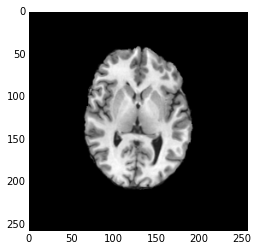

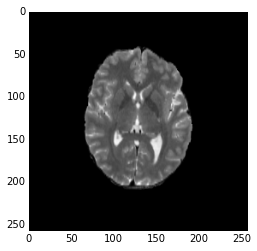

In [19]:
myshow(dwi_b0)
myshow(t1d)
myshow(t2d)

In [20]:
print(t1d.GetSize())
print(t1d.GetDirection())
print(t1d.GetOrigin())

print(t2d.GetSize())
print(t2d.GetDirection())
print(t2d.GetOrigin())

print(dwi_b0.GetSize())
print(dwi_b0.GetDirection())
print(dwi_b0.GetOrigin())

(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)
(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)
(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)


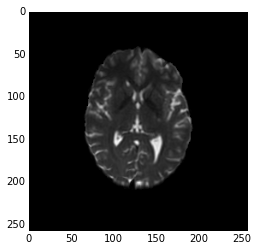

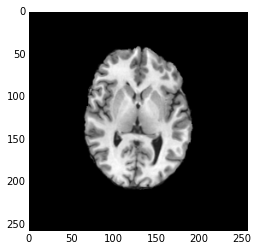

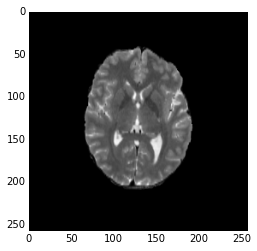

In [21]:
#
# Write images to the disk for checking their alignment in slicer
sitk.WriteImage(t1d,os.path.join(OutputDir,'t1_inVoxelSpace.nii.gz'))
sitk.WriteImage(t2d,os.path.join(OutputDir,'t2_inVoxelSpace.nii.gz'))
sitk.WriteImage(dwi_b0,os.path.join(OutputDir,'dwi_b0_inVoxelSpace.nii.gz'))
#
#
#
#
# Now we follow all processes in 2D space
# 's' means slice
t1d_s = t1d[:,:,t1d.GetSize()[2]/2]
t2d_s = t2d[:,:,t2d.GetSize()[2]/2]
dwib0_s = dwi_b0[:,:,dwi_b0.GetSize()[2]/2]

myshow(dwib0_s)
myshow(t1d_s)
myshow(t2d_s)
#
#

In [22]:
# Now we have following goals:
# 1) save the axial 2d dwi file (dwib0_s) as a matlab file in "MatlabFiles" directory.
# 2) Create edge mask from cobinations of t1d_s and t2d_s

In [23]:
def NormalizeBetweenZeroAndOne(image):
    image_double = sitk.Cast(image, sitk.sitkFloat32)
    # new range
    newMax=1.0
    newMin=0
    # Find old range
    totalStats = sitk.StatisticsImageFilter()
    totalStats.Execute(image_double)
    oldMax=totalStats.GetMaximum()
    oldMin=totalStats.GetMinimum()
    f=(newMax-newMin)/(oldMax-oldMin)
    Normalized_image = (image_double-oldMin)*f+newMin
    return Normalized_image

In [24]:
# GOAL 1

In [25]:
print(dwib0_s.GetSize())
print(dwib0_s.GetSpacing())

#print(dwib0_s.GetPixelIDTypeAsString())
# This step is important because "Undefined function 'fftn' for input arguments of type 'int16'"
#dwib0_s = sitk.Cast(dwib0_s, sitk.sitkUInt16)
#print(dwib0_s.GetPixelIDTypeAsString())


# Now normalize dwi_b0 to have values between 0 and 1
dwib0_s = NormalizeBetweenZeroAndOne(dwib0_s)

im_arr = sitk.GetArrayFromImage(dwib0_s)

import scipy.io
scipy.io.savemat(os.path.join(MatlabFilesDir,'testdata.mat'), mdict={'inputImage': im_arr})

(256, 256)
(1.0, 1.0000000000000004)


In [26]:
# GOAL 2

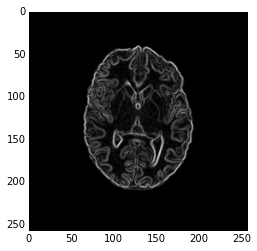

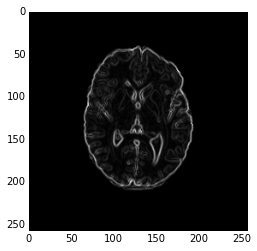

In [27]:
t1g = sitk.GradientMagnitude(t1d_s)
t2g = sitk.GradientMagnitude(t2d_s)
myshow(t1g)
myshow(t2g)

In [28]:
#sitk.WriteImage(t1g,os.path.join(OutputDir,'gradMag_t1_denoised.nii.gz'))
#sitk.WriteImage(t2g,os.path.join(OutputDir,'gradMag_t2_denoised.nii.gz'))

In [29]:
stats = sitk.StatisticsImageFilter()
stats.Execute(t1g)
t1gMax = stats.GetMaximum()
t1gMean = stats.GetMean()

stats.Execute(t2g)
t2gMax = stats.GetMaximum()
t2gMean = stats.GetMean()

print(t1gMax)
print(t2gMax)
print(t1gMean)
print(t2gMean)

1739.86645508
1658.81738281
74.0065971708
48.1220477124


In [30]:
#maskROI1 = t1g > t1gMax/10
#maskROI2 = t2g > t1gMax/10

maskROI1 = t1g > t1gMean
maskROI2 = t2g > t2gMean

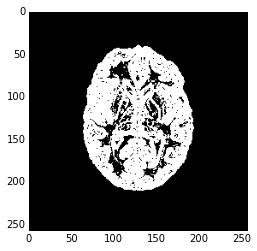

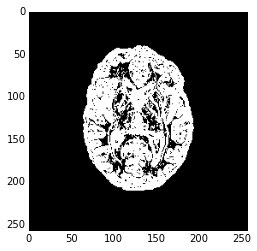

In [31]:
myshow(maskROI1)
myshow(maskROI2)

In [32]:
mask1 = maskROI1 & maskROI2
mask2 = maskROI1 | maskROI2

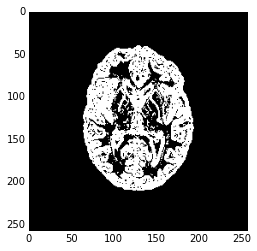

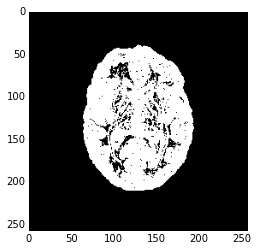

In [33]:
myshow(mask1)
myshow(mask2)

In [34]:
Lstat = sitk.LabelStatisticsImageFilter()
Lstat.Execute(t1g,mask1)
t1_avg_1 = Lstat.GetMean(1)
print("t1 average 1: {0}".format(t1_avg_1))

Lstat.Execute(t1g,mask2)
t1_avg_2 = Lstat.GetMean(1)
print("t1 average 2: {0}".format(t1_avg_2))

t1 average 1: 368.976290068
t1 average 2: 313.130275469


In [35]:
Lstat.Execute(t2g,mask1)
t2_avg_1 = Lstat.GetMean(1)
print("t2 average 1: {0}".format(t2_avg_1))

Lstat.Execute(t2g,mask2)
t2_avg_2 = Lstat.GetMean(1)
print("t2 average 2: {0}".format(t2_avg_2))

t2 average 1: 243.247755989
t2 average 2: 203.553668209


In [36]:
# find m and b for "t2 = m * t1 + b"
m = (t2_avg_1-t2_avg_2)/(t1_avg_1-t1_avg_2)
print(m)

b = t2_avg_1 - (m*t1_avg_1)
print(b)

0.710777448754
-19.0122701163


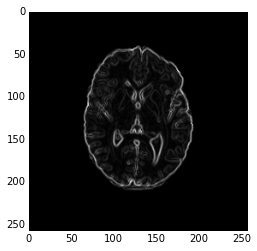

In [37]:
# t2 = m * t1 + b
# t2' = m' * t1
# if m'=1 --> t2' = (t2-b)/m
# linearize
t2gl = (t2g - b)/m
myshow(t2gl)

In [38]:
totalStats = sitk.StatisticsImageFilter()

totalStats.Execute(t1g)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

totalStats.Execute(t2gl)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

1739.86645508
0.0
2360.55566406
26.7485542297


1808.64282227
13.3742771149


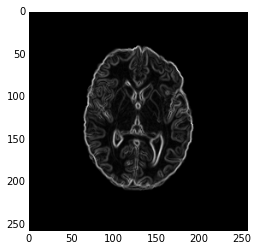

In [39]:
edgeMask = (t1g+t2gl)/2
myshow(edgeMask)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

In [40]:
# Now normalize both t1g and t2g to have values between 0 and 1
edgeMask = NormalizeBetweenZeroAndOne(edgeMask)

In [41]:
# invert the edge mask
inverter = sitk.InvertIntensityImageFilter()
edgeMask = inverter.Execute(edgeMask,1)

In [42]:
totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

1.0
0.0


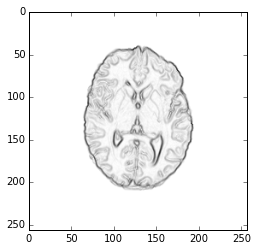

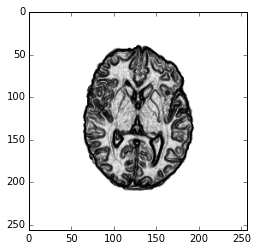

In [43]:
myshow(edgeMask)

#sqrtedgeMask = sitk.Sqrt(edgeMask)
sqredgeMask = sitk.Square(edgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)

myshow(sqredgeMask)

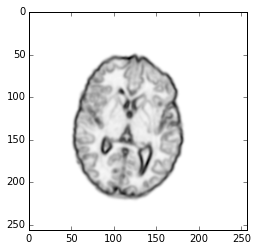

In [59]:
# rotate the edgemask a little intentionally!
rigTx = sitk.Euler2DTransform()
#rigTx.SetAngle(0.017*3)
rigTx.SetAngle(0.017*-2)

resampler3 = sitk.ResampleImageFilter()
resampler3.SetReferenceImage(edgeMask)
resampler3.SetTransform(rigTx)
resampler3.SetDefaultPixelValue(1)
edgeMask = resampler3.Execute(edgeMask)
myshow(edgeMask)

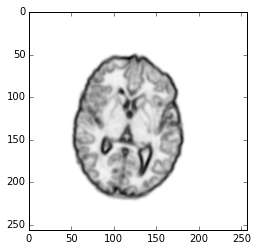

In [61]:
edgeMask = sitk.Square(edgeMask)
myshow(edgeMask)

In [62]:
#edge_arr = sitk.GetArrayFromImage(edgeMask)
edge_arr = sitk.GetArrayFromImage(edgeMask)

import scipy.io
scipy.io.savemat(os.path.join(MatlabFilesDir,'edgemask.mat'), mdict={'edgeMask': edge_arr})